In [14]:
#导入需要的库
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [15]:
#载入MOBILENETV2模型
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
#weights: 二选一：None（代表随机初始化权重）或者"imagenet"（代表读入在ImageNet上预训练的权重）。
pretrained_model.trainable = False

In [16]:
# 对图像预处理，使得图像可以输入MobileNetV2模型
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

#image_path = tf.keras.utils.get_file(fname='grace_hopper.jpg', origin='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#image_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
#image_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)

90112/83281 [================================] - 0s 5us/step


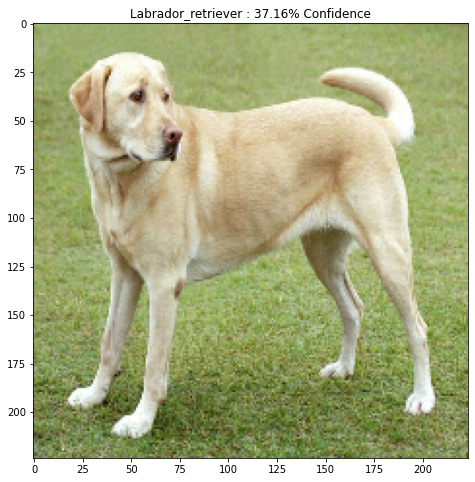

In [17]:
#将图像输入模型并得到概率最高的分类结果
def get_imagenet_label(probs):
    return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]#只获取第一个

image_probs = pretrained_model.predict(image)#模型预测,输入测试集,输出预测结果---概率
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [18]:
#计算梯度
loss_object = tf.keras.losses.CategoricalCrossentropy()#损失函数--交叉熵损失函数

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:#梯度带
        tape.watch(input_image) #watch函数把需要计算梯度的变量input_image加进
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient) # 符号梯度攻击
    return signed_grad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


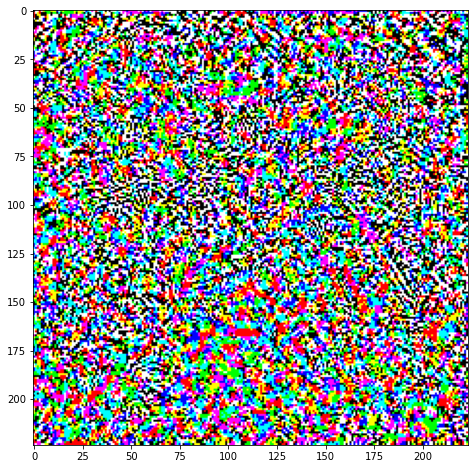

In [19]:
#将要添加的噪声打印出来
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])


In [20]:
#定义函数来展示被攻击过的图像
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

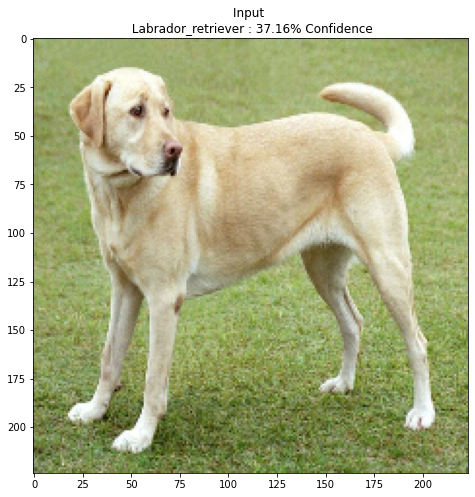

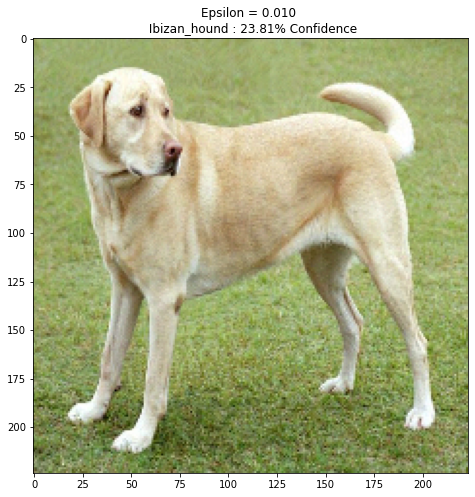

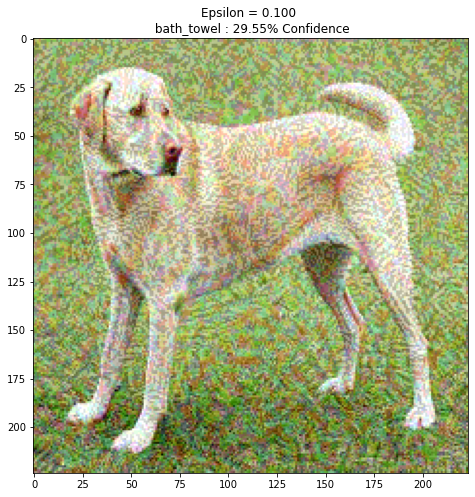

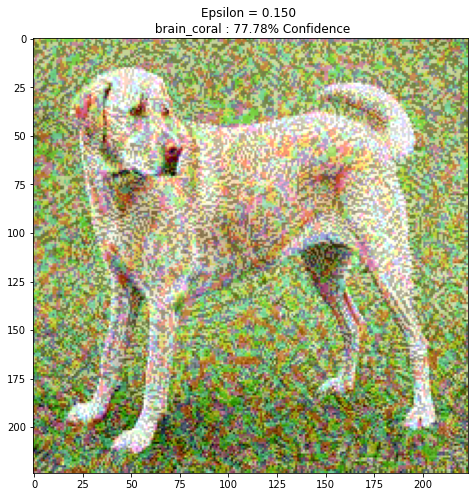

In [21]:
#加入噪声后再将图像输入模型进行判断
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1) # 将值限制在[0,1]范围内
    display_images(adv_x, descriptions[i])